In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_recall_curve, roc_auc_score, 
                             roc_curve, f1_score)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [14]:
print("=" * 80)
print("STEP 1: DATA LOADING & EXPLORATION")
print("=" * 80)

df = pd.read_csv("Telco_customer_churn.csv")

print(f" Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f" Churn Rate: {df['Churn Value'].mean():.1%}")
print(f"   - Churned: {df['Churn Value'].sum():,} customers")
print(f"   - Retained: {(df['Churn Value'] == 0).sum():,} customers")


STEP 1: DATA LOADING & EXPLORATION
 Dataset Shape: 7043 rows, 33 columns
 Churn Rate: 26.5%
   - Churned: 1,869 customers
   - Retained: 5,174 customers


In [15]:
 df = pd.read_csv("Telco_customer_churn.csv")

In [33]:
print("\n" + "=" * 80)
print("STEP 2: DATA CLEANING & FEATURE ENGINEERING")
print("=" * 80)

# We use df directly now
# Fix Total Charges data type issue
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df.dropna(subset=['Total Charges'], inplace=True)

print(f" Cleaned Total Charges column")
print(f"   Records after cleaning: {len(df):,}")

# FEATURE 1: Engagement Score (number of active services)
service_cols = ['Online Security', 'Online Backup', 'Device Protection', 
                'Tech Support', 'Streaming TV', 'Streaming Movies']
df['Engagement_Score'] = df[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)
print(f" Feature 1: Engagement Score (0-6 active services)")

# FEATURE 2: Average Monthly Spend (proxy for usage intensity)
df['Avg_Monthly_Spend'] = df['Total Charges'] / df['Tenure Months'].replace(0, 1)
print(f" Feature 2: Average Monthly Spend")

# FEATURE 3: Tenure Categories (customer lifecycle stage)
df['Tenure_Category'] = pd.cut(df['Tenure Months'], 
                                 bins=[0, 12, 36, np.inf], 
                                 labels=['New_0-12mo', 'Mid_12-36mo', 'Loyal_36mo+'])
print(f" Feature 3: Tenure Categories (New/Mid/Loyal)")

# FEATURE 4: Contract Risk Score (month-to-month = higher risk)
df['Contract_Risk'] = (df['Contract'] == 'Month-to-Month').astype(int)
print(f" Feature 4: Contract Risk (Month-to-Month flag)")

# FEATURE 5: Payment Method Risk (Electronic check = less stable)
df['Payment_Risk'] = (df['Payment Method'] == 'Electronic check').astype(int)
print(f" Feature 5: Payment Risk (Electronic check flag)")

# FEATURE 6: Service Density (services per dollar spent)
df['Service_Density'] = df['Engagement_Score'] / df['Monthly Charges'].replace(0, 0.01)
print(f" Feature 6: Service Density ")

# FEATURE 7: Revenue Concentration (high total charges but low tenure = rapid spender)
df['Revenue_Velocity'] = df['Total Charges'] / (df['Tenure Months'].replace(0, 1) + 1)
print(f" Feature 7: Revenue Velocity")

# Drop non-predictive columns
drop_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 
             'Lat Long', 'Latitude', 'Longitude', 'Churn Reason', 'Churn Label']
df.drop([col for col in drop_cols if col in df.columns], axis=1, inplace=True)

print(f" Engineered 7 business-relevant features")


STEP 2: DATA CLEANING & FEATURE ENGINEERING
 Cleaned Total Charges column
   Records after cleaning: 7,032
 Feature 1: Engagement Score (0-6 active services)
 Feature 2: Average Monthly Spend
 Feature 3: Tenure Categories (New/Mid/Loyal)
 Feature 4: Contract Risk (Month-to-Month flag)
 Feature 5: Payment Risk (Electronic check flag)
 Feature 6: Service Density 
 Feature 7: Revenue Velocity
 Engineered 7 business-relevant features


In [19]:
print("\n" + "=" * 80)
print("STEP 3: DATA PREPROCESSING")
print("=" * 80)

# Separate features and target
X = df.drop(['Churn Value'], axis=1)
y = df['Churn Value']

# One-hot encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

feature_names = X_encoded.columns

print(f" Encoded {len(cat_cols)} categorical variables")
print(f"   Final feature count: {X_encoded.shape[1]}")

# Train-test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Train/Test Split:")
print(f"   Training: {len(X_train):,} samples ({len(X_train)/len(X_encoded):.0%})")
print(f"   Testing:  {len(X_test):,} samples ({len(X_test)/len(X_encoded):.0%})")
print(f"   Train churn rate: {y_train.mean():.1%}")
print(f"   Test churn rate:  {y_test.mean():.1%}")


STEP 3: DATA PREPROCESSING
 Encoded 17 categorical variables
   Final feature count: 40
   Train/Test Split:
   Training: 5,625 samples (80%)
   Testing:  1,407 samples (20%)
   Train churn rate: 26.6%
   Test churn rate:  26.6%


In [20]:
print("\n" + "=" * 80)
print("STEP 4: HANDLING CLASS IMBALANCE")
print("=" * 80)

# Define method
imbalance_method = 'smote'

print(f"\n Original class distribution:")
print(f"   Class 0 (No Churn): {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"   Class 1 (Churn):    {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")

if imbalance_method == 'smote':
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    
    print(f"\n Applied SMOTE oversampling")
    print(f"   New class distribution:")
    print(f"   Class 0: {(y_train_bal == 0).sum():,} ({(y_train_bal == 0).mean():.1%})")
    print(f"   Class 1: {(y_train_bal == 1).sum():,} ({(y_train_bal == 1).mean():.1%})")
else:
    print(f"\n Using class_weight='balanced' in model")
    X_train_bal, y_train_bal = X_train, y_train



STEP 4: HANDLING CLASS IMBALANCE

 Original class distribution:
   Class 0 (No Churn): 4,130 (73.4%)
   Class 1 (Churn):    1,495 (26.6%)

 Applied SMOTE oversampling
   New class distribution:
   Class 0: 4,130 (50.0%)
   Class 1: 4,130 (50.0%)


In [21]:
print("\n" + "=" * 80)
print("STEP 5: MODEL TRAINING & EVALUATION")
print("=" * 80)

# Train Random Forest with balanced class weights
print(" Training Random Forest Classifier...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_bal, y_train_bal)
print(" Model trained successfully")

# Cross-validation score
cv_scores = cross_val_score(model, X_train_bal, y_train_bal, cv=5, scoring='roc_auc')
print(f" Cross-Validation ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\n" + "=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)

print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f" ROC-AUC Score: {roc_auc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"   Confusion Matrix:")
print(f"   True Negatives:  {cm[0,0]:,} | False Positives: {cm[0,1]:,}")
print(f"   False Negatives: {cm[1,0]:,} | True Positives:  {cm[1,1]:,}")


STEP 5: MODEL TRAINING & EVALUATION
 Training Random Forest Classifier...
 Model trained successfully
 Cross-Validation ROC-AUC: 0.988 (+/- 0.007)

MODEL PERFORMANCE METRICS
 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.97      0.94      0.95      1033
       Churn       0.84      0.92      0.88       374

    accuracy                           0.93      1407
   macro avg       0.90      0.93      0.91      1407
weighted avg       0.93      0.93      0.93      1407

 ROC-AUC Score: 0.977
   Confusion Matrix:
   True Negatives:  968 | False Positives: 65
   False Negatives: 31 | True Positives:  343



STEP 6: GENERATING VISUALIZATIONS
 Saved visualization: model_performance_dashboard.png


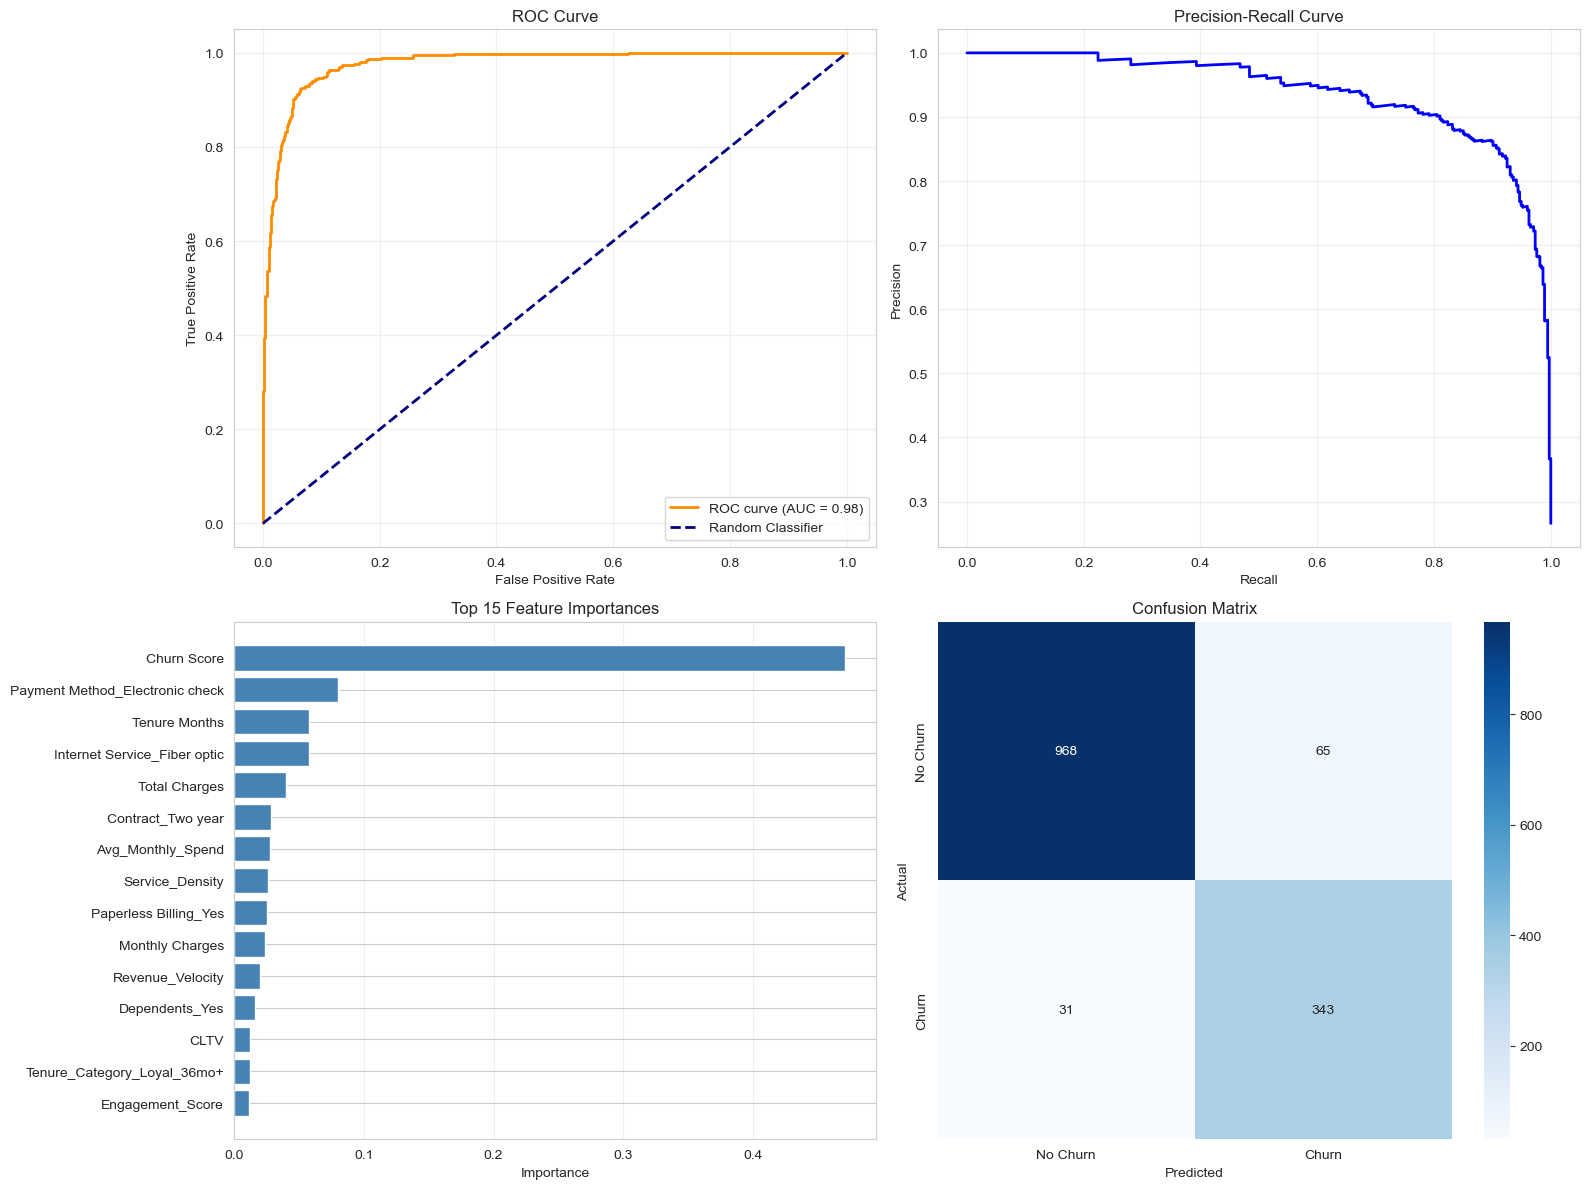

In [22]:
print("\n" + "=" * 80)
print("STEP 6: GENERATING VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_val = roc_auc_score(y_test, y_pred_proba)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
axes[0, 1].plot(recall, precision, color='blue', lw=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature Importance (Top 15)
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1, 0].barh(range(len(importances)), importances['Importance'], color='steelblue')
axes[1, 0].set_yticks(range(len(importances)))
axes[1, 0].set_yticklabels(importances['Feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 15 Feature Importances')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Confusion Matrix Heatmap
cm_hm = confusion_matrix(y_test, (y_pred_proba > 0.5).astype(int))
sns.heatmap(cm_hm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig('model_performance_dashboard.png', dpi=300, bbox_inches='tight')
print(" Saved visualization: model_performance_dashboard.png")
plt.show()


In [29]:
print("\n" + "=" * 80)
print("STEP 7: BUSINESS COST-BENEFIT ANALYSIS")
print("=" * 80)


#Business parameters
CAMPAIGN_COST = 500  # Cost to contact one customer
CLV = 50000  # Customer Lifetime Value
CAMPAIGN_SUCCESS_RATE = 0.40  # 40% of contacted churners are retained
TOTAL_CUSTOMERS = 7000

print(f"\n💰 Business Assumptions:")
print(f"   Campaign cost per customer:     ₹{CAMPAIGN_COST:,}")
print(f"   Customer Lifetime Value (CLV):  ₹{CLV:,}")
print(f"   Campaign success rate:          {CAMPAIGN_SUCCESS_RATE:.0%}")
print(f"   Total customer base:            {TOTAL_CUSTOMERS:,}")


#Calculate Net benefit at different thresholds 
precison_cb, recall_cb, thresholds_cb = precision_recall_curve(y_test, y_pred_proba)

net_benefits = []
for threshold in thresholds_cb:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    #Calculating confusion matrix components
    #true positives
    tp = ((y_pred_threshold == 1) & (y_test == 1)).sum()
    #false positives
    fp = ((y_pred_threshold == 1) & (y_test == 0)).sum()
    #false negatives 
    fn = ((y_pred_threshold == 0) & (y_test == 1)).sum()
    #True Negatives 
    tn = ((y_pred_threshold == 0) & (y_test ==  0)).sum()

    #calculate financial impact 
    #Benefit : Value of retained customers(tp * success rate * CLV)
    benefit = tp * CAMPAIGN_SUCCESS_RATE * CLV 

    #Cost : Campaign costs for all contacted(TP + FP) * cost 
    cost = (tp + fp) * CAMPAIGN_COST 

    #Oppurtunity cost : Low customers we didn't contact(FN * CLV) 
    opportunity_cost = fn * CLV 

    #Net Benefit 
    net = benefit - cost

    net_benefits.append({
         'threshold': threshold,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'benefit': benefit,
        'cost': cost,
        'opportunity_cost': opportunity_cost,
        'net_benefit': net
    })
df_benefits = pd.DataFrame(net_benefits)
#find optimal threshold 
optimal_idx = df_benefits['net_benefit'].idxmax()
optimal_row = df_benefits.iloc[optimal_idx]
optimal_threshold = optimal_row['threshold']

print(f" OPTIMAL DECISION THRESHOLD: {optimal_row['threshold']:.3f}")
print(f"  Model Performance at Optimal Threshold:")
print(f"   - Precision: {optimal_row['precision']:.1%}")
print(f"   - Recall:    {optimal_row['recall']:.1%}")
print(f"  Business Impact (on test set of {len(y_test):,} customers):")
print(f"   - Customers contacted:        {int(optimal_row['tp'] + optimal_row['fp']):,}")
print(f"   - Actual churners identified: {int(optimal_row['tp']):,}")
print(f"   - Customers retained:         {int(optimal_row['tp'] * CAMPAIGN_SUCCESS_RATE):,}")
print(f"   - Campaign cost:              Rs{optimal_row['cost']:,.0f}")
print(f"   - Value retained:             Rs{optimal_row['benefit']:,.0f}")
print(f"   - NET BENEFIT:                Rs{optimal_row['net_benefit']:,.0f}")

scale_factor = TOTAL_CUSTOMERS/ len(y_test)
annual_benefit = optimal_row['net_benefit'] * scale_factor 

print(f" PROJECTED ANNUAL IMPACT (scaled to {TOTAL_CUSTOMERS:,} customers):")
print(f"   - Estimated churners:         {int(y_test.sum() * scale_factor):,}")
print(f"   - Customers to contact:       {int((optimal_row['tp'] + optimal_row['fp']) * scale_factor):,}")
print(f"   - Expected retentions:        {int(optimal_row['tp'] * CAMPAIGN_SUCCESS_RATE * scale_factor):,}")
print(f"   - Total campaign cost:        Rs{optimal_row['cost'] * scale_factor:,.0f}")
print(f"   - Total value retained:       Rs{optimal_row['benefit'] * scale_factor:,.0f}")
print(f"   - PROJECTED NET BENEFIT:      Rs{annual_benefit:,.0f}")








STEP 7: BUSINESS COST-BENEFIT ANALYSIS

💰 Business Assumptions:
   Campaign cost per customer:     ₹500
   Customer Lifetime Value (CLV):  ₹50,000
   Campaign success rate:          40%
   Total customer base:            7,000
 OPTIMAL DECISION THRESHOLD: 0.102
  Model Performance at Optimal Threshold:
   - Precision: 58.3%
   - Recall:    99.5%
  Business Impact (on test set of 1,407 customers):
   - Customers contacted:        638
   - Actual churners identified: 372
   - Customers retained:         148
   - Campaign cost:              Rs319,000
   - Value retained:             Rs7,440,000
   - NET BENEFIT:                Rs7,121,000
 PROJECTED ANNUAL IMPACT (scaled to 7,000 customers):
   - Estimated churners:         1,860
   - Customers to contact:       3,174
   - Expected retentions:        740
   - Total campaign cost:        Rs1,587,065
   - Total value retained:       Rs37,014,925
   - PROJECTED NET BENEFIT:      Rs35,427,861



✅ Saved visualization: cost_benefit_analysis.png


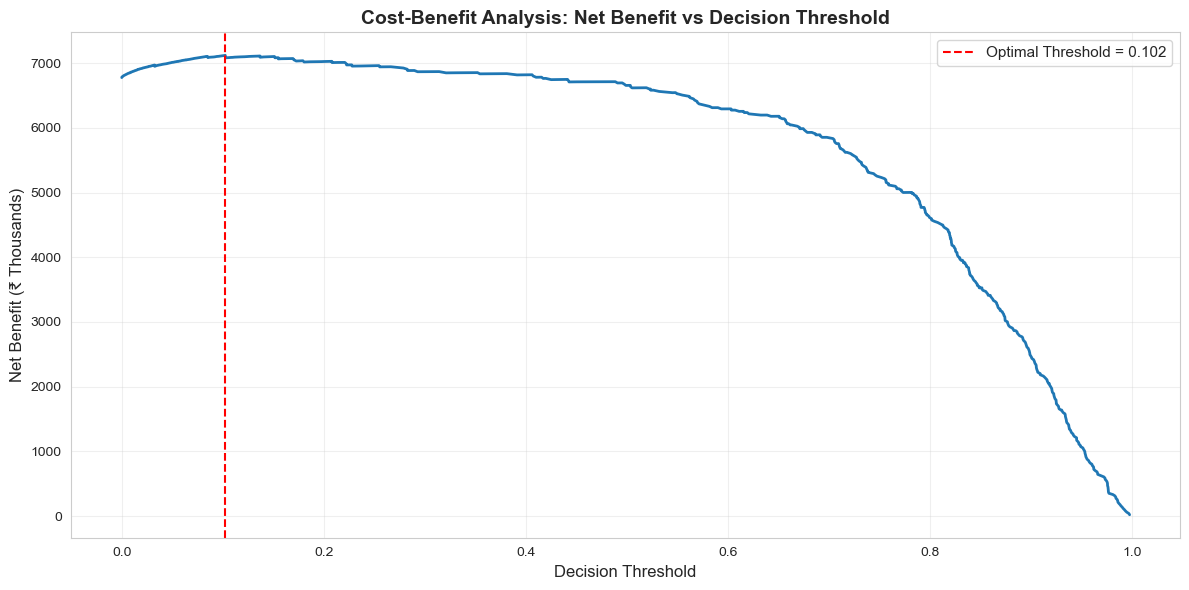

In [30]:
# Plot net benefit curve
plt.figure(figsize=(12, 6))
plt.plot(df_benefits['threshold'], df_benefits['net_benefit'] / 1000, linewidth=2)
plt.axvline(optimal_row['threshold'], color='red', linestyle='--', 
            label=f'Optimal Threshold = {optimal_row["threshold"]:.3f}')
plt.xlabel('Decision Threshold', fontsize=12)
plt.ylabel('Net Benefit (₹ Thousands)', fontsize=12)
plt.title('Cost-Benefit Analysis: Net Benefit vs Decision Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cost_benefit_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved visualization: cost_benefit_analysis.png")
plt.show()

In [32]:
print("\n" + "=" * 80)
print("STEP 8: HIGH-RISK CUSTOMER SEGMENTATION")
print("=" * 80)

# Prepare features for prediction
# Note: In the procedural script, 'df' still has all the features from Section 2
X_seg = df.drop(['Churn Value'], axis=1)
cat_cols_seg = X_seg.select_dtypes(include=['object', 'category']).columns
X_encoded_seg = pd.get_dummies(X_seg, columns=cat_cols_seg, drop_first=True)

# Ensure all training features are present
for col in feature_names:
    if col not in X_encoded_seg.columns:
        X_encoded_seg[col] = 0
X_encoded_seg = X_encoded_seg[feature_names]

# Predict churn probability
churn_proba_seg = model.predict_proba(X_encoded_seg)[:, 1]
df_analysis = df.copy()
df_analysis['Churn_Probability'] = churn_proba_seg
df_analysis['High_Risk'] = (churn_proba_seg >= optimal_threshold).astype(int)

# Segment analysis
print(f" High-Risk Customer Segments:")
print(f"   Total high-risk customers: {df_analysis['High_Risk'].sum():,} ({df_analysis['High_Risk'].mean():.1%})")

# Segment by contract type
print(f"  By Contract Type:")
contract_segments = df_analysis.groupby('Contract')['High_Risk'].agg(['sum', 'mean', 'count'])
contract_segments.columns = ['High_Risk_Count', 'Churn_Rate', 'Total']
contract_segments = contract_segments.sort_values('Churn_Rate', ascending=False)
print(contract_segments.to_string())

# Segment by tenure
print(f"  By Tenure Category:")
if 'Tenure_Category' in df_analysis.columns:
    tenure_segments = df_analysis.groupby('Tenure_Category')['High_Risk'].agg(['sum', 'mean', 'count'])
    tenure_segments.columns = ['High_Risk_Count', 'Churn_Rate', 'Total']
    tenure_segments = tenure_segments.sort_values('Churn_Rate', ascending=False)
    print(tenure_segments.to_string())

# Segment by engagement
df_analysis['Engagement_Level'] = pd.cut(df_analysis['Engagement_Score'], 
                                          bins=[-1, 1, 3, 6], 
                                          labels=['Low (0-1)', 'Medium (2-3)', 'High (4-6)'])
print(f"  By Engagement Level:")
engagement_segments = df_analysis.groupby('Engagement_Level')['High_Risk'].agg(['sum', 'mean', 'count'])
engagement_segments.columns = ['High_Risk_Count', 'Churn_Rate', 'Total']
engagement_segments = engagement_segments.sort_values('Churn_Rate', ascending=False)
print(engagement_segments.to_string())

# Export high-risk customer list
high_risk_customers = df_analysis[df_analysis['High_Risk'] == 1].sort_values('Churn_Probability', ascending=False)
high_risk_customers[['Churn_Probability', 'Contract', 'Tenure_Category', 
                     'Engagement_Score', 'Monthly Charges']].head(100).to_csv(
    'high_risk_customers_for_campaign.csv', index=False
)
print(f" Exported top 100 high-risk customers to: high_risk_customers_for_campaign.csv")


STEP 8: HIGH-RISK CUSTOMER SEGMENTATION
 High-Risk Customer Segments:
   Total high-risk customers: 3,031 (43.1%)
  By Contract Type:
                High_Risk_Count  Churn_Rate  Total
Contract                                          
Month-to-month             2467    0.636645   3875
One year                    404    0.274457   1472
Two year                    160    0.094955   1685
  By Tenure Category:
                 High_Risk_Count  Churn_Rate  Total
Tenure_Category                                    
New_0-12mo                  1535    0.705747   2175
Mid_12-36mo                  788    0.424569   1856
Loyal_36mo+                  708    0.235921   3001
  By Engagement Level:
                  High_Risk_Count  Churn_Rate  Total
Engagement_Level                                    
Medium (2-3)                 1068    0.496744   2150
Low (0-1)                    1433    0.450771   3179
High (4-6)                    530    0.311216   1703
 Exported top 100 high-risk customers to